#  Heterogenous Discount Factors 

In [1]:


from ConsIndShockModel import IndShockConsumerType
import time
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from HARK.distribution import DiscreteDistribution, MeanOneLogNormal,Lognormal,Uniform,combine_indep_dstns
from scipy import sparse as sp
from HARK.utilities import get_lorenz_shares
from tqdm import tqdm


In [2]:

def lin(x):
    return x


In [3]:

def jump_to_grid_1D(m_vals, probs ,Dist_mGrid ):
    
    '''
    Distributes values onto a predefined grid, maintaining the means.
    
    
    Parameters
    ----------
    m_vals: np.array
            Market resource values 
    probs: np.array
            Shock probabilities associated with combinations of m_vals. 
            Can be thought of as the probability mass function  of (m_vals).
    
    dist_mGrid : np.array
            Grid over normalized market resources
    Returns
    -------
    probGrid.flatten(): np.array
             Probabilities of each gridpoint on the combined grid of market resources
  
    ''' 

    probGrid = np.zeros(len(Dist_mGrid))
    mIndex = np.digitize(m_vals,Dist_mGrid) - 1
    mIndex[m_vals <= Dist_mGrid[0]] = -1
    mIndex[m_vals >= Dist_mGrid[-1]] = len(Dist_mGrid)-1
    
 
    for i in range(len(m_vals)):
        if mIndex[i]==-1:
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i]==len(Dist_mGrid)-1:
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else:
            mlowerIndex = mIndex[i]
            mupperIndex = mIndex[i]+1
            mlowerWeight = (Dist_mGrid[mupperIndex]-m_vals[i])/(Dist_mGrid[mupperIndex]-Dist_mGrid[mlowerIndex])
            mupperWeight = 1.0 - mlowerWeight
            
        probGrid[mlowerIndex] +=  probs[i]*mlowerWeight
        probGrid[mupperIndex] +=  probs[i]*mupperWeight
        
    return probGrid.flatten()



In [4]:


## lorenz curve
def lorenz_curve(grid_distribution,
                 pdfs,
                 nb_share_grid = 50):
    
    """
    parameters
    ======
    grid_distribution: grid on which distribution is defined
    pdfs: the fractions/pdfs of each grid ranges 
    
    return
    ======
    lc_vals: the fraction of people corresponding whose total wealth reaches the corresponding share, x axis in lorenz curve
    share_grids: different grid points of the share of total wealth, y axis in lorenz curve
    """
    total = np.dot(grid_distribution,pdfs)
    share_grids = np.linspace(-.15,0.9999,nb_share_grid)
    share_cum = np.multiply(grid_distribution,pdfs).cumsum()/total
    lc_vals = []
    for i,share in enumerate(share_grids):
        where = min([x for x in range(len(share_cum)) if share_cum[x]>=share])
        this_lc_val = pdfs[0:where].sum()
        lc_vals.append(this_lc_val)
    return np.array(lc_vals),share_grids



In [5]:
1.04 / (1.0 - 1.0 / 160.0)

1.0465408805031446

In [6]:
# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree":  1.01 / (1.0 - 1.0 / 160.0) ,  # Survival probability,
    "PermGroFac": [1.0],#[1.000**0.25],  # Permanent income growth factor (no perm growth),
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax": 1000,  # Maximum end-of-period assets in grid
    "aXtraCount": 100,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.97,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    "T_sim": 1600,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_age": None,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,
}


In [7]:

# This cell constructs seven instances of IndShockConsumerType with different discount factors
from HARK.distribution import Uniform

BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)
BaselineType.track_vars = ["aLvl", "cNrm", "pLvl"]
# Specify the distribution of the discount factor
num_types = 7  # number of types we want
DiscFac_mean = 0.9855583  # center of beta distribution
DiscFac_spread = 0.0085  # spread of beta distribution
DiscFac_dstn = (
    Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)
    .approx(num_types)
    .X.flatten()
)

MyTypes = []  # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = deepcopy(BaselineType)
    NewType.DiscFac = DiscFac_dstn[nn]
    NewType.seed = nn  # give each consumer type a different RNG seed
    MyTypes.append(NewType)


In [8]:
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.define_distribution_grid(num_pointsP = 80,timestonest = 3)
    ThisType.calc_transition_matrix()
    ThisType.calc_ergodic_dist()

  0%|          | 0/7 [00:00<?, ?it/s]GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 14%|█▍        | 1/7 [01:09<06:55, 69.27s/it]GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 29%|██▊       | 2/7 [02:12<05:28, 65.63s/it]GPFRaw                 = 0.999206 
GPFNrm                 = 1.002470 
GPFAggLivPrb           = 0.992961 
Thorn = APF            = 0.999206 
PermGroFacAdj          = 0.996744

In [9]:

def jump_to_grid_1D(m_vals, probs ,Dist_mGrid ):
    
    '''
    Distributes values onto a predefined grid, maintaining the means.
    
    
    Parameters
    ----------
    m_vals: np.array
            Market resource values 
    probs: np.array
            Shock probabilities associated with combinations of m_vals. 
            Can be thought of as the probability mass function  of (m_vals).
    
    dist_mGrid : np.array
            Grid over normalized market resources
    Returns
    -------
    probGrid.flatten(): np.array
             Probabilities of each gridpoint on the combined grid of market resources
  
    ''' 

    probGrid = np.zeros(len(Dist_mGrid))
    mIndex = np.digitize(m_vals,Dist_mGrid) - 1
    mIndex[m_vals <= Dist_mGrid[0]] = -1
    mIndex[m_vals >= Dist_mGrid[-1]] = len(Dist_mGrid)-1
    
 
    for i in range(len(m_vals)):
        if mIndex[i]==-1:
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i]==len(Dist_mGrid)-1:
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else:
            mlowerIndex = mIndex[i]
            mupperIndex = mIndex[i]+1
            mlowerWeight = (Dist_mGrid[mupperIndex]-m_vals[i])/(Dist_mGrid[mupperIndex]-Dist_mGrid[mlowerIndex])
            mupperWeight = 1.0 - mlowerWeight
            
        probGrid[mlowerIndex] +=  probs[i]*mlowerWeight
        probGrid[mupperIndex] +=  probs[i]*mupperWeight
        
    return probGrid.flatten()



In [10]:
def compute_pmf(Agent):

    aLvl_vals = []

    for a in Agent.aPol_Grid:

        for p in Agent.dist_pGrid:

            aLvl_vals.append(a*p)

    aLvl_vals = np.array(aLvl_vals)
    pmf = jump_to_grid_1D(aLvl_vals, Agent.vec_erg_dstn, MyTypes[0].aPol_Grid) # probabilities/distribution from transition matrix methods

    return pmf


In [11]:

dstn = np.zeros(100)
for ThisType in tqdm(MyTypes):
    pmf_this_type = compute_pmf(ThisType)
    dstn+= (1/num_types) * pmf_this_type
    

100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


(-10.0, 1000.0)

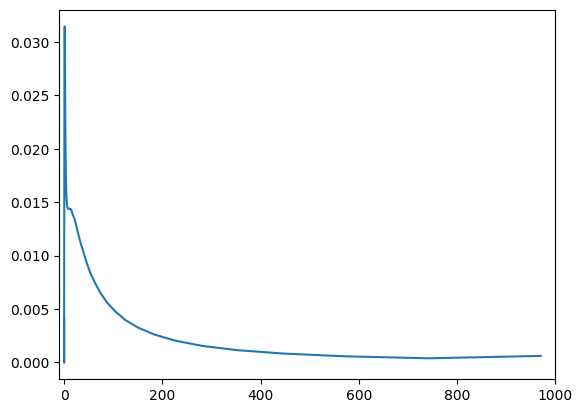

In [12]:
plt.plot(MyTypes[0].aPol_Grid,dstn)
plt.xlim([-10,1000])

In [13]:
MyTypes[0].aPol_Grid[-20]

25.869615991050544

In [14]:
lorenz1 = get_lorenz_shares(MyTypes[0].aPol_Grid,dstn,[.1,.2,.4,.6,.8,.9,.95,.98], False)

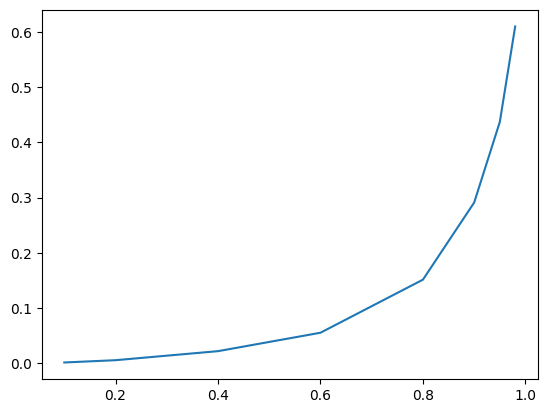

In [15]:
plt.plot([.1,.2,.4,.6,.8,.9,.95,.98],lorenz1)


# Monte Carlo

In [16]:


Generator = False  # Is this notebook the master or is it generated?
# Import related generic python packages

# Set how many digits past the decimal point should be printed?
mystr = lambda number: "{:.4f}".format(number)
decfmt4 = lambda number: "{:.4f}".format(number)
decfmt3 = lambda number: "{:.3f}".format(number)
decfmt2 = lambda number: "{:.2f}".format(number)
decfmt1 = lambda number: "{:.1f}".format(number)

# Progress bar keeps track interactively of how many have been made
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.initialize_sim()
    ThisType.simulate()

    
aLvl_all = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
print(
    "The ratio of aggregate capital to permanent income is "
    + decfmt2(np.mean(aLvl_all))
)





  0%|          | 0/7 [00:00<?, ?it/s]GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 14%|█▍        | 1/7 [00:45<04:34, 45.75s/it]GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 29%|██▊       | 2/7 [01:33<03:55, 47.11s/it]GPFRaw                 = 0.999206 
GPFNrm                 = 1.002470 
GPFAggLivPrb           = 0.992961 
Thorn = APF            = 0.999206 
PermGroFacAdj          = 0.996744

The ratio of aggregate capital to permanent income is 15.37


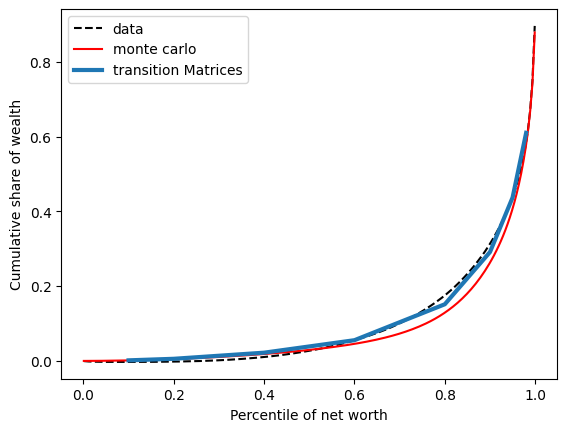

In [17]:
# Plot Lorenz curves for model with uniform distribution of time preference
from HARK.datasets import load_SCF_wealth_weights
from HARK.utilities import get_lorenz_shares, get_percentiles

SCF_wealth, SCF_weights = load_SCF_wealth_weights()

pctiles = np.linspace(0.001, 0.999, 200)
sim_wealth = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)
plt.plot(pctiles, SCF_Lorenz_points, "--k", label = 'data')
plt.plot(pctiles, sim_Lorenz_points, "-r", label = 'monte carlo')
plt.plot([.1,.2,.4,.6,.8,.9,.95,.98],lorenz1, label = 'transition Matrices', linewidth = 3.0, linestyle = '-')
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend()
plt.show(block=False)


In [18]:
ThisType

<ConsIndShockModel.IndShockConsumerType object at 0x13493e330d0.
Parameters:
cycles: 0
CRRA: 1.0
Rfree: 1.0163522012578616
DiscFac: 0.97
LivPrb: [0.99375]
PermGroFac: [1.0]
BoroCnstArt: 0.0
MaxKinks: 400
AgentCount: 10000
aNrmInitMean: -11.512925464970229
aNrmInitStd: 0.0
pLvlInitMean: 0.0
pLvlInitStd: 0.0
PermGroFacAgg: 1.0
T_age: None
T_cycle: 1
PerfMITShk: False
aXtraMin: 1e-05
aXtraMax: 1000
aXtraNestFac: 3
aXtraCount: 100
aXtraExtra: [None]
PermShkStd: [0.06030226891555272]
PermShkCount: 5
TranShkStd: [0.2]
TranShkCount: 5
UnempPrb: 0.07
UnempPrbRet: 0.07
IncUnemp: 0.15
IncUnempRet: 0.15
tax_rate: 0.0
T_retire: 0
vFuncBool: False
CubicBool: False
neutral_measure: False
NewbornTransShk: False
T_sim: 1600
IndL: 1.1111111111111112>

In [19]:
MyTypes[-1].DiscFac

0.9928440142857142

In [21]:
AggA = []
AggC = []
for i in range(len(MyTypes[0].history['aLvl'])):
    
    AggC.append(np.mean(MyTypes[-1].history['cNrm'][i] *MyTypes[-1].history['pLvl'][i] ))
    AggA.append( np.mean(MyTypes[-1].history['aLvl'][i]))
    
    
    
    

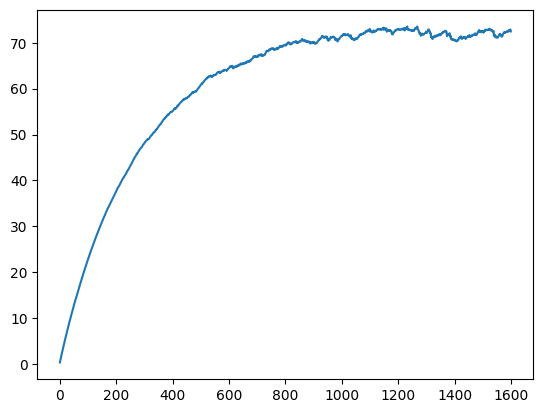

In [22]:
plt.plot(AggA)

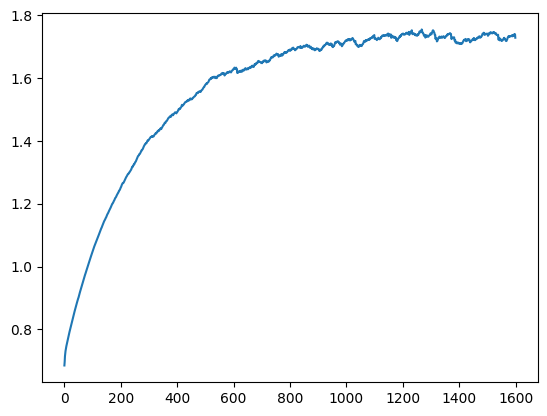

In [23]:
plt.plot(AggC)